<a href="https://colab.research.google.com/github/Martin09/DeepSEM/blob/master/obj_detection-NW_yield/3_nw_yield_yield_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3 - Model loading and NW yield analysis
In this notebook we will:
1. Load an image for analysis.
2. Load our previously-trained model.
3. Use model to label the SEM image.
4. Perform post-processing on model output to calculate the NW yield


## Install detectron2

In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
Requirement already up-to-date: torch==1.5 in /usr/local/lib/python3.6/dist-packages (1.5.0+cu101)
Requirement already up-to-date: torchvision==0.6 in /usr/local/lib/python3.6/dist-packages (0.6.0+cu101)
     |████████████████████████████████| 276kB 3.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44074 sha256=24b5c18719e7c6879bcd801f00023a62fa348ebd4d3371f97fb3cb36a3665463
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-sw5okot5
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-sw5okot5
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-lin

In [2]:
# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html
     |████████████████████████████████| 6.2MB 616kB/s 
  Created wheel for fvcore: filename=fvcore-0.1.1.post20200611-cp36-none-any.whl size=41026 sha256=0e90684fb2875b680e1d5fd8af0768ae4b5b13a5c459fbeab2d88aee58d7777b
  Stored in directory: /root/.cache/pip/wheels/d2/eb/15/e71cb12830acdedf55806d66c214157ed61702f8ae97273b56
Successfully built fvcore


In [0]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
from glob import glob
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

## 3.1 - Unpack and load our image

In [4]:
# Clone the DeepSEM repository
!rm -rf DeepSEM
!git clone https://github.com/Martin09/DeepSEM

# OR

# # Load from GoogleDrive
# from google.colab import drive
# drive.mount('/content/gdrive/')
# %cd "/content/gdrive/My Drive/path/to/your/data"

Cloning into 'DeepSEM'...
remote: Enumerating objects: 100, done.
remote: Counting objects: 100% (100/100), done.
remote: Compressing objects: 100% (87/87), done.
remote: Total 458 (delta 55), reused 24 (delta 11), pack-reused 358
Receiving objects: 100% (458/458), 110.28 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (203/203), done.


In [5]:
dataset_dir = './DeepSEM/obj_detection-NW_yield/datasets/NWs-8kMag-rawtiffs/'
!wget https://github.com/Martin09/DeepSEM/raw/master/obj_detection-NW_yield/datasets/NWs-8kMag-rawtiffs.zip
!unzip NWs-8kMag-rawtiffs.zip -d $dataset_dir
!rm NWs-8kMag-rawtiffs.zip

--2020-06-11 09:56:01--  https://github.com/Martin09/DeepSEM/raw/master/obj_detection-NW_yield/datasets/NWs-8kMag-rawtiffs.zip
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Martin09/DeepSEM/master/obj_detection-NW_yield/datasets/NWs-8kMag-rawtiffs.zip [following]
--2020-06-11 09:56:02--  https://raw.githubusercontent.com/Martin09/DeepSEM/master/obj_detection-NW_yield/datasets/NWs-8kMag-rawtiffs.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7171575 (6.8M) [application/zip]
Saving to: ‘NWs-8kMag-rawtiffs.zip’

NWs-8kMag-rawtiffs. 100%[===================>]   6.84M  26.5MB/s    in 0.3s    

2020

Load an image and show it.

(768, 1024)


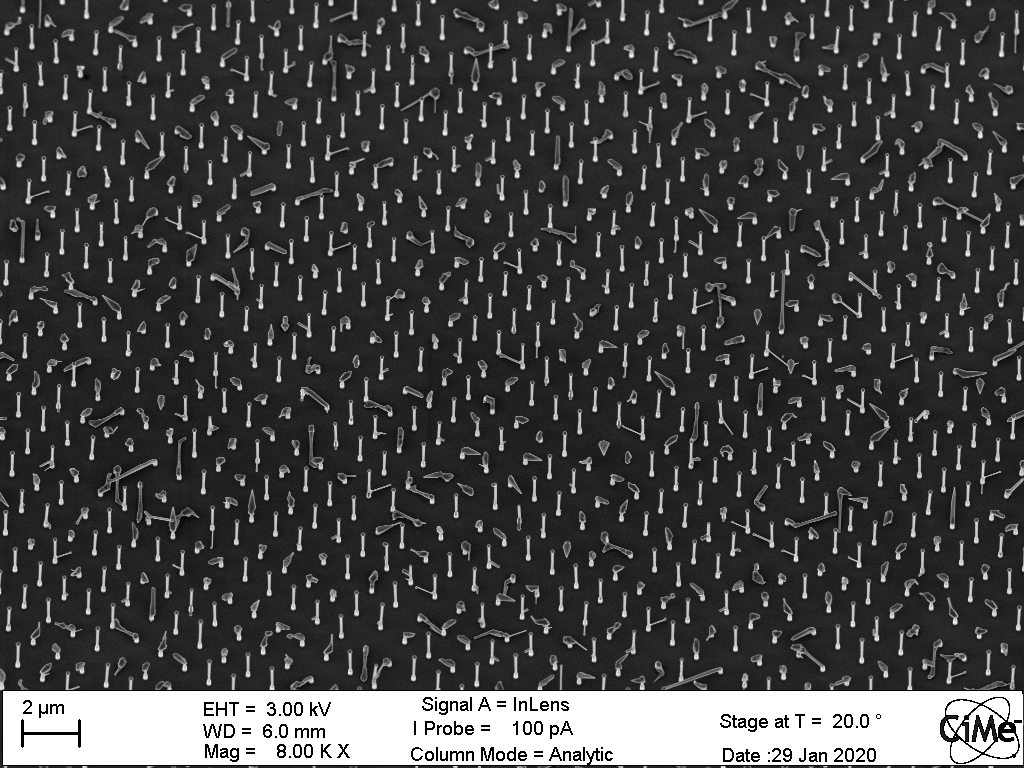

In [6]:
# im = cv2.imread("./DeepSEM/obj_detection-NW_yield/datasets/NWs-8kMag-subdivided/135nm_20_cropped_x0_y0.png", cv2.IMREAD_GRAYSCALE)
im = cv2.imread("./DeepSEM/obj_detection-NW_yield/datasets/NWs-8kMag-rawtiffs/140nm_16.tif", cv2.IMREAD_GRAYSCALE)

print(im.shape)
cv2_imshow(im)

Do some pre-processing to get it ready to feed into our model.

(768, 1024, 3)
(688, 1024, 3)


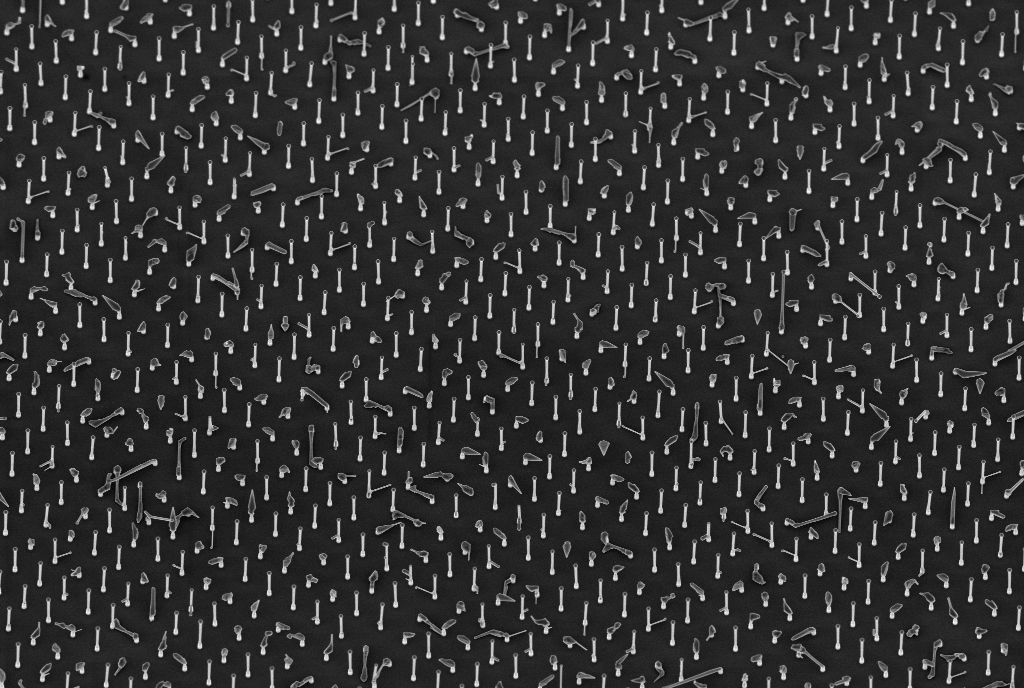

In [7]:
# Model expects an RGB image, so copy the greyscale data into other 2 channels
im_RGB = np.repeat(im[:, :, np.newaxis], 3, axis=2)
print(im_RGB.shape)

# Trim off the bottom overlay to not confuse the model (if needed)
im_RGB = im_RGB[:688,:,:] 
print(im_RGB.shape)
cv2_imshow(im_RGB)

## 3.2 - Load our model

Now we will load a trained model and use it to label the above image. First we load a default config with `get_cfg()` and we then overwrite some of its parameters with our saved YAML configuration file. 

One important point is that we need to have `cfg.MODEL.WEIGHTS` set to point to the weights file. As this file can be quite big (>300MB) and since Github isn't designed to host big binary files, I have saved the weights for this model on my Google Drive instead. However, if you have your weights saved locally (ex: on your Google Drive), you can skip this download.

In [8]:
# Weights file that we would like to load
weights_file = './DeepSEM/obj_detection-NW_yield/trained_models/nw_yield_it10k_loss0.133.pth'

# Check if it exists, if not, download a weights file from Google Drive
import os
file_id = '1K_XnLc69uA2FRSdIFPs-WvTSrAXKwve2'
if os.path.isfile(weights_file):
  print('Weights file already exists. Skipping download!')
else:
  print('Weights file does not exist... Downloading!')
  !gdown --id $file_id -O $weights_file

Weights file does not exist... Downloading!
Downloading...
From: https://drive.google.com/uc?id=1K_XnLc69uA2FRSdIFPs-WvTSrAXKwve2
To: /content/DeepSEM/obj_detection-NW_yield/trained_models/nw_yield_it10k_loss0.133.pth
330MB [00:01, 181MB/s]


Now we can go ahead with the rest of the configuration of the model.

In [9]:
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog

model_path = './DeepSEM/obj_detection-NW_yield/trained_models/nw_yield_it10k_loss0.133.yaml'
# model_path = './DeepSEM/obj_detection-NW_yield/trained_models/nw_yield_it99_loss0.93.yaml'

cfg = get_cfg()
cfg.merge_from_file(model_path)
cfg.MODEL.WEIGHTS = weights_file
cfg.MODEL.DEVICE = 'cpu'  # CPU is enough for inference, no need for GPU

# If we have a lot of objects to detect, need to set higher # of proposals here:
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 10000
cfg.MODEL.RPN.PRE_NMS_TOPK_TEST = 10000
cfg.TEST.DETECTIONS_PER_IMAGE = 10000

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # Set the testing threshold for this model
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.2     # Non-max supression threshold

# Setting allowed input sizes (avoid scaling)
cfg.INPUT.MIN_SIZE_TEST = 0
cfg.INPUT.MAX_SIZE_TEST = 99999

# A bit of a hacky way to be able to use the DefaultPredictor:
# Register a "fake" dataset to then set the 'thing_classes' metadata
# (there is probably a better way to do this...)
cfg.DATASETS.TEST = ('placeholder')
DatasetCatalog.clear()
DatasetCatalog.register("placeholder", lambda _: None)
MetadataCatalog.get("placeholder").set(thing_classes=["nw","parasitic","nanospade"])

Metadata(name='placeholder', thing_classes=['nw', 'parasitic', 'nanospade'])

## 3.3 - Performing inference
Create a predictor, and run the predictor on the image to generate the outputs.

In [10]:
predictor = DefaultPredictor(cfg)
outputs = predictor(im_RGB)
print('Number of detected objects = {}'.format(len(outputs["instances"])))

Number of detected objects = 943


In [0]:
# Verify outputs manually
# outputs["instances"].pred_classes
# outputs["instances"].pred_boxes
# outputs["instances"].scores

Now we can visualize the output of the model.

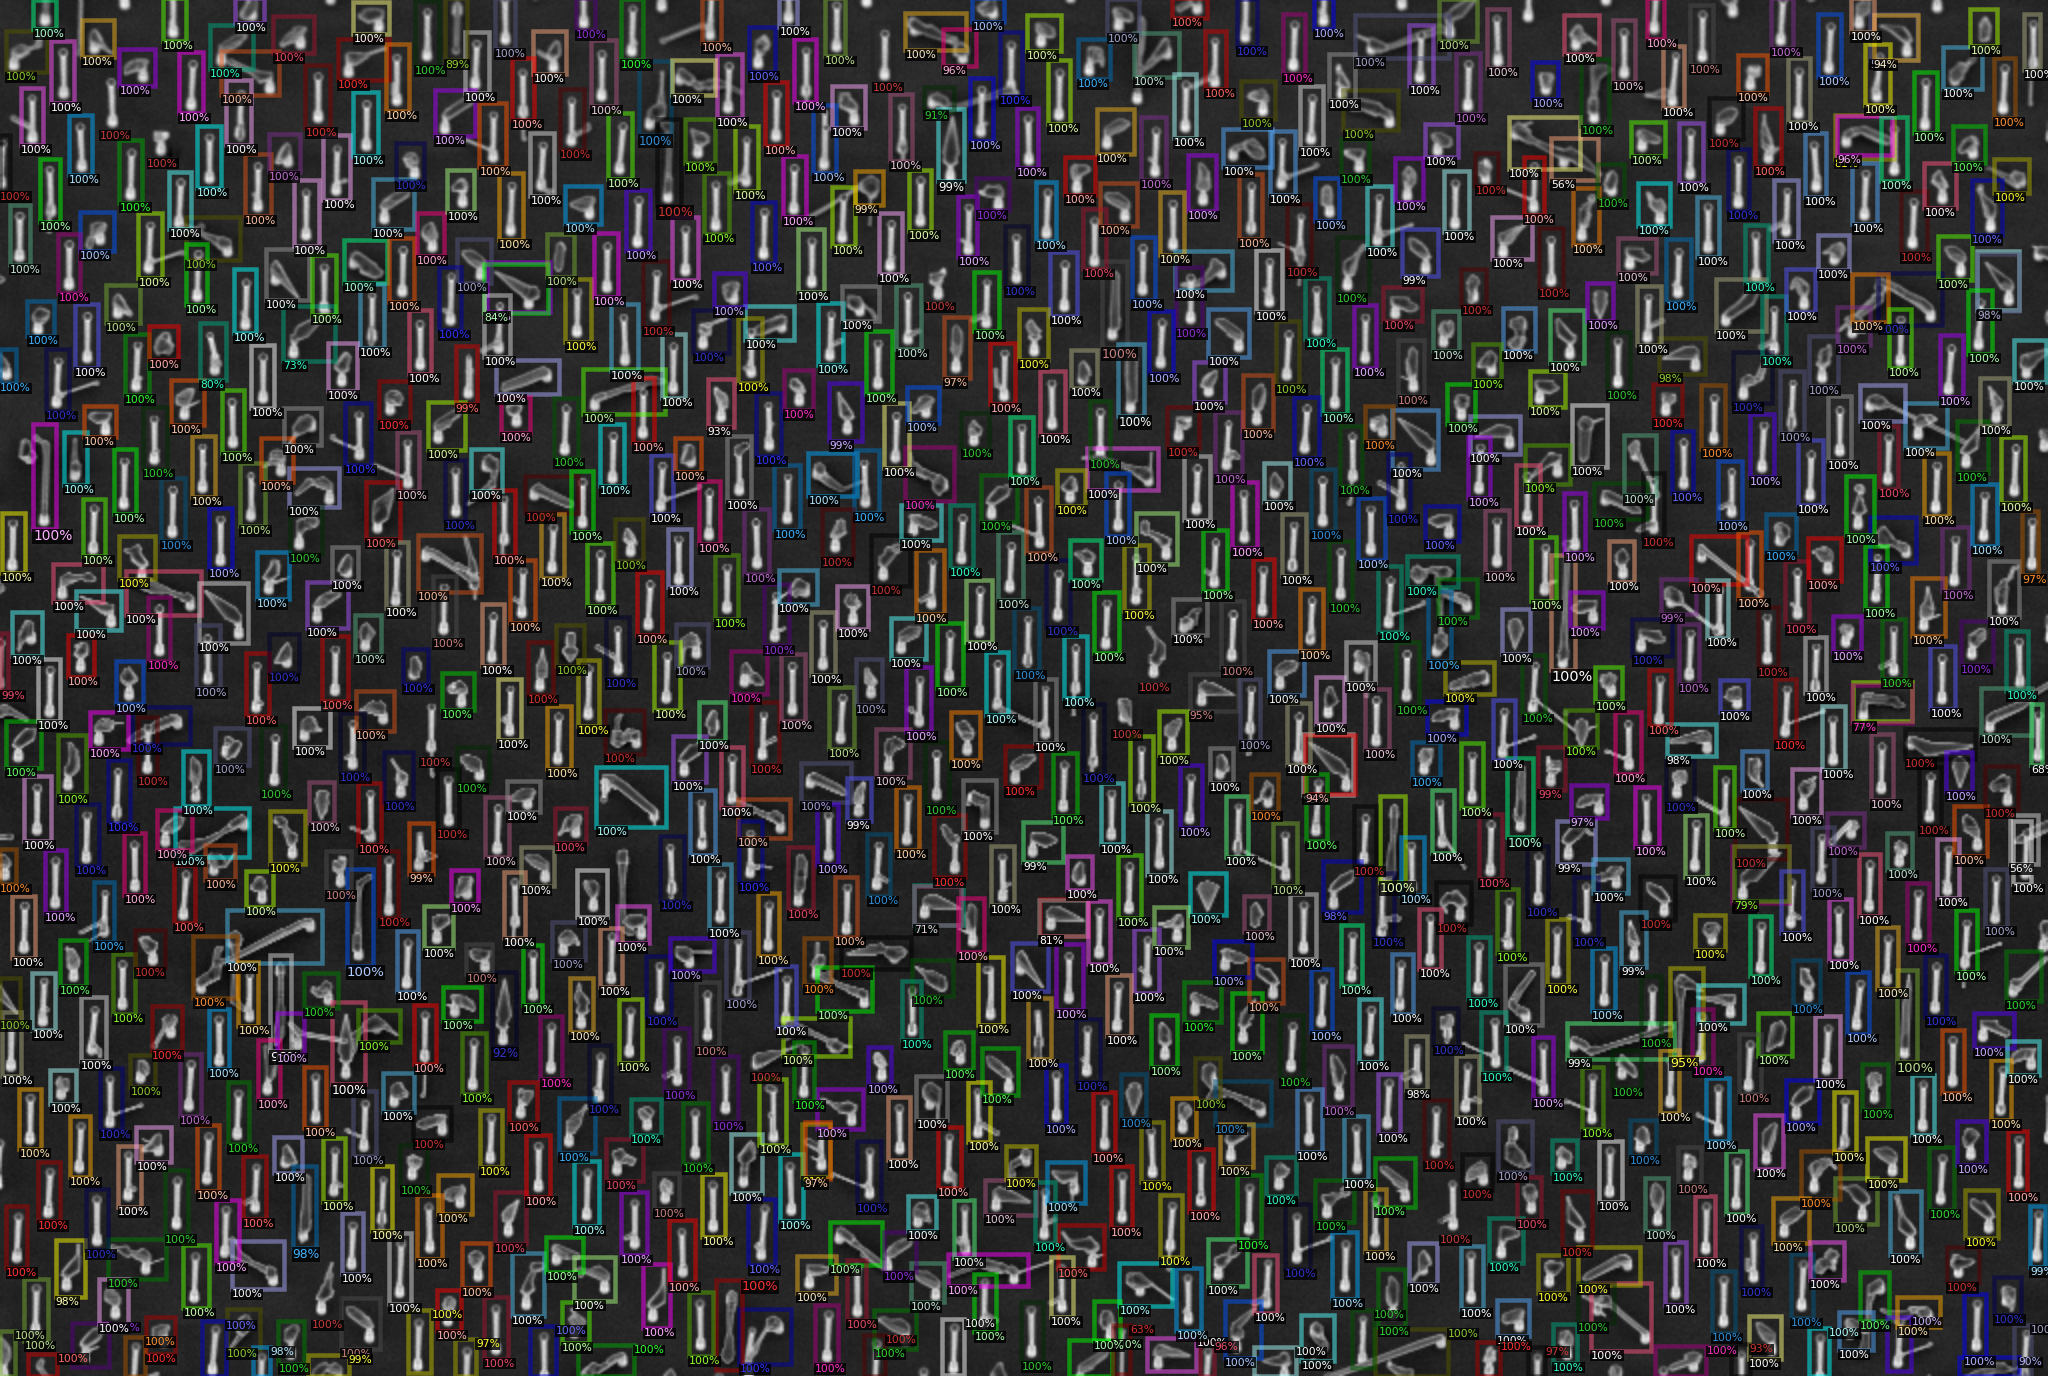

In [12]:
# We can use Visualizer to draw the predictions on the image.
v = Visualizer(im_RGB[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TEST[0]), scale=2.0)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

Hopefully you should see that almost all the objects in the full-scale SEM image have now been labelled. We can also play a bit with the `SCORE_THRESH_TEST` and `NMS_THRESH_TEST` to fine-tune the output of the model.

## 3.4 - Post-processing model output

However, just getting the output from the model isn't enough. Now we have to do quite a bit of work to post-process the output and extract a nanowire yield from this. Let's do this!

Massage the output a bit to get it into a single numpy array for easy filtering.

In [0]:
cl = np.array(outputs["instances"].pred_classes.cpu())  # Classes
s = np.array(outputs["instances"].scores.cpu()) # Prediction scores
b =  np.array([x.numpy() for x in outputs["instances"].pred_boxes])  # Bounding boxes
c = np.array(outputs["instances"].pred_boxes.get_centers())  # Bounding box centres
predictions = np.column_stack([cl,s,b,c])

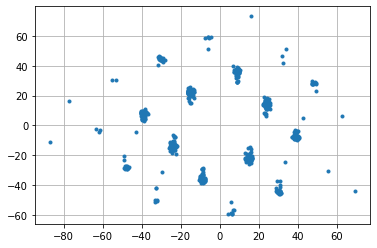

In [14]:
from matplotlib import pyplot as plt

# Select only NW predictions
predictions = predictions[predictions[:,0]==0]

# Extract NW bounding box centres
centres = predictions[:,-2:]
C = centres  # Tensor variable notation to use later in matrix calculations

# Loop over NW bounding box centres. For each one, find vector for 3 closest NWs
vectors = []
for p in centres:

    # Build a tensor as large as centres tensor
    p = p[np.newaxis]
    P = np.repeat(p, len(C), axis=0)

    # Calculate distance to all other NWs in a vectorized way
    D = np.linalg.norm(C - P, axis=1)
    n = 3 # Number of minimum distances to extract
    i_min = np.argsort(-D)[-1-n:-1]  # Find "n" minimum distances
    V = C[i_min] - np.repeat(p, n, axis=0)
    vectors.extend(V.squeeze().tolist())

vectors = np.array(vectors)
lengths = np.linalg.norm(vectors, axis=1)

plt.plot(vectors[:,0], vectors[:,1],'.')
plt.grid()

Above we have a plot of the nanowire grid from which we can now extract the grid vectors. First, however, we will do some outlier removal with scikit-learn.

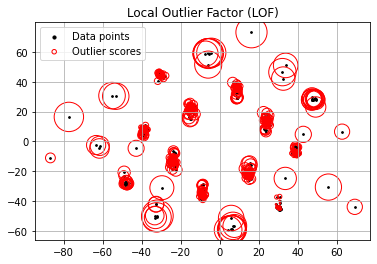

In [15]:
from sklearn.neighbors import LocalOutlierFactor

X = vectors

# Fit model for local outlier function
clf = LocalOutlierFactor(n_neighbors=25, contamination=0.1, algorithm='auto')
_ = clf.fit_predict(X)  # Make prediction of outliers
X_scores = clf.negative_outlier_factor_  # Get outlier scores (lower score means more of an outlier)

# Plot outlier analysis
plt.title("Local Outlier Factor (LOF)")
plt.scatter(X[:, 0], X[:, 1], color='k', s=3., label='Data points')

radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(X[:, 0], X[:, 1], s=1000 * radius, edgecolors='r',
            facecolors='none', label='Outlier scores')
plt.grid()
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

Can now filter the points based on their "outlier scores" to get only the grid vectors that we are interested in.

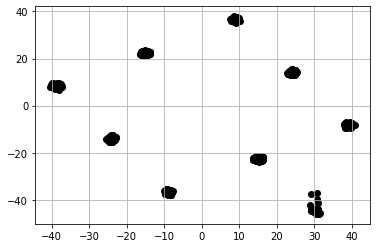

In [16]:
X_filt = X[X_scores[:] > -1.5,:]  # Filter points based on outlier scores
plt.scatter(X_filt[:, 0], X_filt[:, 1], color='k')
plt.grid()

We have many point groups now, we just need to find those that correspond to the unit vectors (shortest). So we apply an additional step of filtering and extract only the shortest vectors by plotting a histogram.

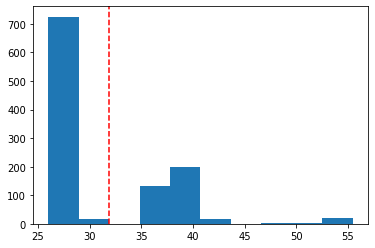

In [17]:
D = np.linalg.norm(X_filt,axis=1)
n, bins, _ = plt.hist(D)

i_max = np.argsort(n)[-1]  # Find index of maximum
i_filt = list(n).index(0,i_max)  # After this maximum, find first index where N=0

# Filter out all vectors that are longer than this
D_f = bins[i_filt]
plt.axvline(x=D_f,ls='--',color='r') # Plot red line to show where filter cut-off is
X_filt2 = X_filt[np.linalg.norm(X_filt,axis=1) < D_f]

Apply k-means clustering to the filtered list to extract the remaining four points.

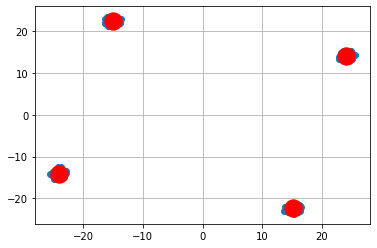

In [18]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=0)
pred_y = kmeans.fit_predict(X_filt2)
plt.scatter(X_filt2[:,0], X_filt2[:,1])
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.grid()

Convert those 4 points into the two grid vectors that we need.




In [19]:
tmp_pos = [x for x in kmeans.cluster_centers_ if x[0] > 0 and x[1] > 0][0]
tmp_neg = [x for x in kmeans.cluster_centers_ if x[0] < 0 and x[1] < 0][0]
v1 = np.mean([tmp_pos,-tmp_neg],axis=0)

tmp_pos = [x for x in kmeans.cluster_centers_ if x[0] > 0 and x[1] < 0][0]
tmp_neg = [x for x in kmeans.cluster_centers_ if x[0] < 0 and x[1] > 0][0]
v2 = np.mean([tmp_pos,-tmp_neg],axis=0)

# Vectors v1 and v2 now characterize the grid on which the NWs appear
print(f'Vector 1 = {v1}')
print(f'Vector 2 = {v2}')

Vector 1 = [24.07408251 14.15089015]
Vector 2 = [ 15.07036347 -22.40170794]


Now we can use these vectors to generate an array of points where we expect to find the NWs.

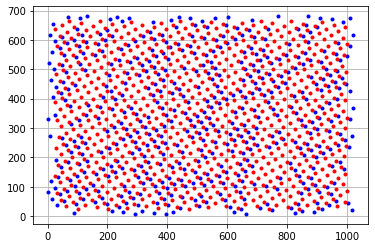

In [20]:
# Determine how many grid points (roughly) we need to generate to cover this image
image_width, image_height = im_RGB.shape[:2]
l_min = np.min([np.linalg.norm(v1),np.linalg.norm(v2)])
n = int(np.max([image_height,image_width])/l_min)+1 # Round up, to be safe

# Generate array of grid points where to look for NWs
grid_pts = np.array(np.meshgrid(range(-n,n), range(-n,n))).T.reshape(-1,2)  # Create standard grid
V = np.column_stack([v1,v2])
grid_pts = grid_pts.dot(V.T) # Coordinate transformation
grid_pts += np.array([image_width, image_height])/2 # Shift grid to centre of image

# Remove points outside image
b = np.max([np.linalg.norm(v1),np.linalg.norm(v2)])*0.8 # Area around edges of image
grid_pts = np.array([[x,y] for x,y in grid_pts if (0+b<x<image_height-b) and (0+b<y<image_width-b)])

# Plot both the grid points and the NW centres together to see if they more or less match
plt.plot(centres[:,0],centres[:,1],'b.')
plt.plot(grid_pts[:,0],grid_pts[:,1],'r.')
plt.grid()

Now we have the grid points, but they are not perfectly aligned to the NW positions, as seen above. Therefore perform some optimization with scipy to minimize the error between the grid points and the NW points.

In [21]:
import numpy as np
from scipy.optimize import leastsq, minimize

def get_grid(grid_pts, shift):
    return grid_pts + np.array(shift)

def get_mean_squared_distance(nw_pts, g_pts):
    err_vector = np.array([0.,0.])
    for p in nw_pts:
        D = np.linalg.norm(g_pts - p, axis=1)
        err_vector += (g_pts[np.argmin(D)] - p)**2
        # err_vector += (g_pts[np.argmin(D)] - p)
    return np.linalg.norm(err_vector)

def err_func(params, nw_centres, grid_pts):
    shifted_grid = get_grid(grid_pts, params)
    err = get_mean_squared_distance(nw_centres, shifted_grid)
    return err

# Find the optimal shift of the grid to minimize error vector for all points
out = minimize(err_func, 
               x0=(4, 5),
               method='Nelder-Mead', 
               args=(centres, grid_pts))    
out

 final_simplex: (array([[ 8.52546861, -3.71520225],
       [ 8.52543129, -3.71515556],
       [ 8.52541426, -3.71529396]]), array([30470.0503308 , 30470.05033114, 30470.0503324 ]))
           fun: 30470.050330801183
       message: 'Optimization terminated successfully.'
          nfev: 91
           nit: 46
        status: 0
       success: True
             x: array([ 8.52546861, -3.71520225])

out.x gives us the optimized shift that minimizes the error.

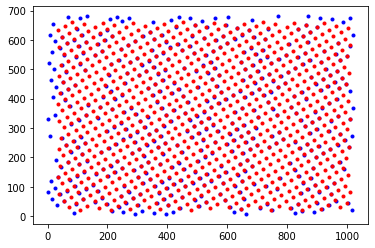

In [22]:
# Apply the optimized shift to the grid and plot it
new_grid_pts = grid_pts + out.x
plt.plot(centres[:,0],centres[:,1],'b.')
plt.plot(new_grid_pts[:,0],new_grid_pts[:,1],'r.')

Now that the point grid and nanowire grid are aligned, can now perform the yield analysis. This is easiest if we transform the coordinates into the grid vector space. This is just the inverse of the transformation matrix that we already created to generate the grid points.

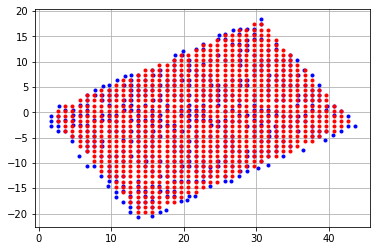

In [23]:
V_inv = np.linalg.inv(V) # Inverse coordinate transformation matrix

# Bring the NW center points back into grid vector space
centres_vcoords = centres.dot(V_inv.T)
grid_pts_vcoords = new_grid_pts.dot(V_inv.T)

# Plot them in grid vector space
plt.plot(centres_vcoords[:,0], centres_vcoords[:,1],'b.')
plt.plot(grid_pts_vcoords[:,0],grid_pts_vcoords[:,1],'r.')
plt.grid()

Now we can loop over each grid point and look for a corresponding NW that is <0.5 grid vector units away in both x and y.

In [0]:
has_nw_list = [] # Add here if there is a NW in this position or not
patch_list = [] # Add here the coordinates of the patches for later plotting on top of the image
# Loop over all grid points
for pt in grid_pts_vcoords:
    # Calculate distances from this point to all NW centres
    D = np.linalg.norm(centres_vcoords - pt, axis=1)

    # Find the closest NW centre
    closest_nw = centres_vcoords[np.argmin(D)]
    
    # Is this NW within the current grid point unit cell?
    has_nw = pt[0] - 0.5 < closest_nw[0] < pt[0] + 0.5 and pt[1] - 0.5 < closest_nw[1] < pt[1] + 0.5
    has_nw_list.append(has_nw)

    # Save the coordinates of this grid point unit cell for later plotting
    patch = np.array([pt+[0.5,0.5],pt+[-0.5,0.5],pt+[-0.5,-0.5],pt+[0.5,-0.5]])
    patch_list.append(patch)

patch_list = np.array(patch_list)

***Now we have enough information to finally calculate NW yield!***

In [25]:
nw_yield = has_nw_list.count(True)/len(has_nw_list)
print("NW yield is {:.0f}/{:.0f} = {:.0f}%!".format(has_nw_list.count(True), len(has_nw_list), nw_yield*100))

NW yield is 419/837 = 50%!


To visualize this, transform the patches back into original image coordinates and plot the patches based on if there was a NW found in them or not.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  if sys.path[0] == '':


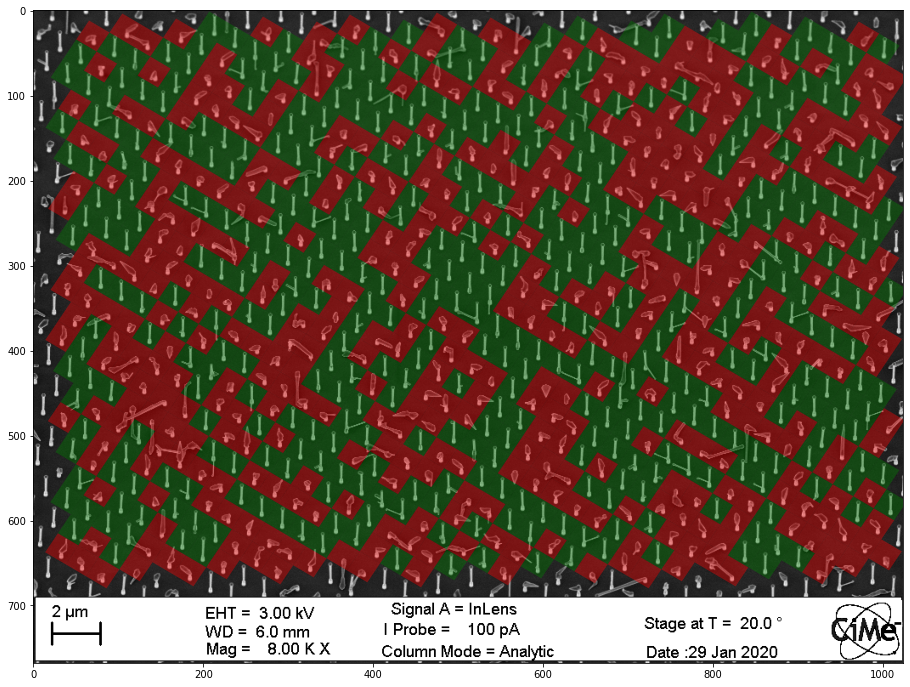

In [26]:
# Transform from grid vector space back into image coordinate space
patches_imgcoords = patch_list.reshape([-1,2]).dot(V.T).reshape([-1,4,2])

# Plot the image
plt.figure(figsize=(20,12))
plt.imshow(im, cmap='gray', vmin=0, vmax=255)
current_axis = plt.gca()

# Plot semi-transparent patches on top
colors = ['r', 'g']
for i, patch in enumerate(patches_imgcoords):
    color = colors[has_nw_list[i]]
    current_axis.add_patch(plt.Polygon(patch, color=color, fill=True, linewidth=0, alpha = 0.4))  

That's it! Hopefully the post-processing steps ran OK for you and you see a nice SEM image with a visual representation of how many NWs were grown compared to parasitic growths.